In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline

import imgaug
import imageio
from imgaug import augmenters as iaa

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout, Input
from keras.applications import ResNet50, VGG16
from keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, Nadam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image
from glob import glob
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define a function to plot learning curves
def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves - ' + title)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Train')
    plt.plot(history.history['val_acc'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves - ' + title)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
path = "/content/drive/MyDrive/Tech-triathlon-2023/Datathon-Dataset-Split/divided_datathon_dataset/"

train_datagen = ImageDataGenerator(rescale=1./255, featurewise_center=False,
                                   rotation_range = 5, fill_mode="nearest",
                                   zoom_range=[1/1.0, 1/1.0], width_shift_range=0.0, height_shift_range=0.0,
                                   horizontal_flip = True, vertical_flip=True,
                                   brightness_range=[0.5, 1.3], channel_shift_range=20)

no_DA_IDG = ImageDataGenerator(rescale=1./255)

# in training set: use data augmentation image data generator, for validation and test: no data augmentation.
training_set = train_datagen.flow_from_directory(path+"train/",
                                                target_size=(64, 64), # typical imagenet dimensions
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical', shuffle=True)



validation_set = no_DA_IDG.flow_from_directory(path+"val/",
                                                target_size=(64, 64),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=1,
                                                shuffle=True)



test_set_V2 = no_DA_IDG.flow_from_directory(path+"test/",
                                                target_size=(64, 64),
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False)

Found 1938 images belonging to 4 classes.
Found 647 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


In [ ]:
training_set.class_indices

{'category1_tumor': 0,
 'category2_tumor': 1,
 'category3_tumor': 2,
 'no_tumor': 3}

In [ ]:
def model_block(input, num_filters):
  x = Conv2D(num_filters, kernel_size = (3,3), padding='same', data_format='channels_last')(input)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(2,2), padding='valid', strides=(2,2), data_format='channels_last')(x)
  return x

In [ ]:
def build_model(input_shape):
  inputs = Input(input_shape)
  x = model_block(inputs, 32)
  x = model_block(x, 64)
  x = model_block(x, 64)
  x = model_block(x, 128)
  x = model_block(x, 256)
  x = GlobalMaxPool2D()(x)
  x = Dense(32, name="dense_32")(x)
  x = Activation('tanh')(x)
  x = Dropout(.24)(x)
  preds = Dense(4,activation='softmax')(x)
  model = Model(inputs=inputs, outputs=preds)
  return model

In [ ]:
model = build_model((64,64,3))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 activation_24 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 activation_25 (Activation)  (None, 32, 32, 64)        0         
                                                           

Epoch 1/30

Epoch 1: val_acc improved from -inf to 0.27512, saving model to /content/drive/MyDrive/Tech-triathlon-2023/best_scratch5_nadam_tanh.h5
1938/1938 - 26s - loss: 1.5417 - acc: 0.2724 - val_loss: 1.3644 - val_acc: 0.2751 - lr: 0.0010 - 26s/epoch - 14ms/step
Epoch 2/30

Epoch 2: val_acc did not improve from 0.27512
1938/1938 - 21s - loss: 1.4578 - acc: 0.2838 - val_loss: 1.3637 - val_acc: 0.2751 - lr: 0.0010 - 21s/epoch - 11ms/step
Epoch 3/30

Epoch 3: val_acc improved from 0.27512 to 0.29057, saving model to /content/drive/MyDrive/Tech-triathlon-2023/best_scratch5_nadam_tanh.h5
1938/1938 - 22s - loss: 1.4210 - acc: 0.2755 - val_loss: 1.3608 - val_acc: 0.2906 - lr: 0.0010 - 22s/epoch - 11ms/step
Epoch 4/30

Epoch 4: val_acc did not improve from 0.29057
1938/1938 - 23s - loss: 1.4070 - acc: 0.2730 - val_loss: 1.3888 - val_acc: 0.2906 - lr: 0.0010 - 23s/epoch - 12ms/step
Epoch 5/30

Epoch 5: val_acc did not improve from 0.29057
1938/1938 - 25s - loss: 1.3883 - acc: 0.2776 - val_lo

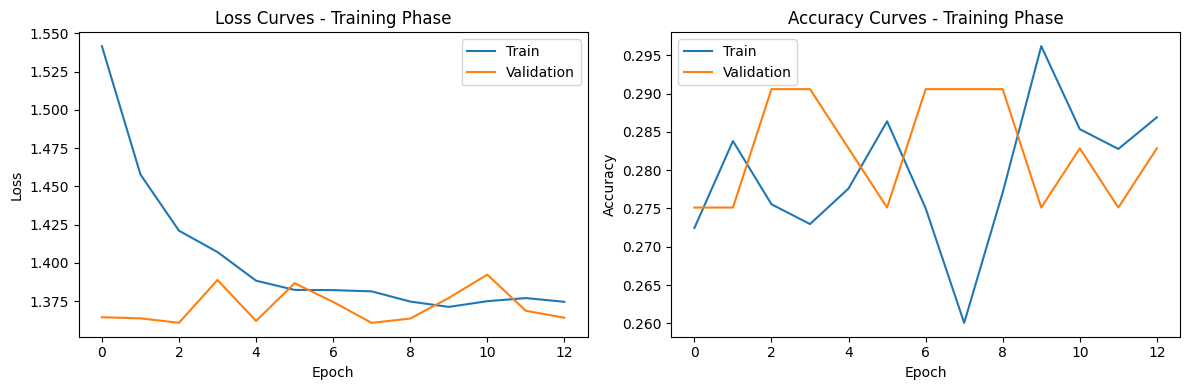

0.2896764252696456
[[  0 184   0   0]
 [  0 188   0   0]
 [  0 179   0   0]
 [  0  98   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       184
           1       0.29      1.00      0.45       188
           2       0.00      0.00      0.00       179
           3       0.00      0.00      0.00        98

    accuracy                           0.29       649
   macro avg       0.07      0.25      0.11       649
weighted avg       0.08      0.29      0.13       649



In [ ]:
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/Tech-triathlon-2023/best_scratch5_nadam_tanh.h5",  # Path to save the best model
    monitor="val_acc",  # Metric to monitor for saving the best model
    save_best_only=True,  # Only save the best model
    mode="max",  # The higher the better for 'val_acc'
    verbose=1  # Print messages about model saving
)

# Create an EarlyStopping callback to stop training if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor="val_acc",  # Metric to monitor for early stopping
    patience=10,  # Number of epochs with no improvement before stopping
    verbose=1,  # Print messages about early stopping
    restore_best_weights=True  # Restore model to best weights when stopping
)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=10, min_lr=1e-5, verbose=1)

epochs = 30
opt = Nadam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_phase = model.fit_generator(generator=training_set,
                                         epochs=epochs,
                                         validation_data=validation_set,
                                         verbose=2,
                                         callbacks=[checkpoint, reduce_lr, early_stopping] )

model.save_weights("/content/drive/MyDrive/Tech-triathlon-2023/best_scratch5_nadam_tanh_weights.h5")


"""EVALUATE PERFORMANCE ON THE TEST SET"""

y_test = test_set_V2.classes
pred = np.argmax(model.predict_generator(test_set_V2, steps = test_set_V2.n), axis=1)

# Plot Learning Curves
plot_learning_curves(history_phase, "Training Phase")

print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))